In [71]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import LogNorm
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [72]:
global GROUND_TRUTH
global NUM_CLASSES
GROUND_TRUTH = ['Background', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2',
                'Fallow', 'Fallow_rough_plow', 'Fallow_smooth', 'Stubble', 'Celery',
                'Grapes_untrained', 'Soil_vinyard_develop', 'Corn_senesced_green_weeds',
                'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk', 'Lettuce_romaine_6wk',
                'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
NUM_CLASSES = len(GROUND_TRUTH)-1

## Load the dataset

In [73]:
data = sio.loadmat('./Salinas_corrected.mat')['salinas_corrected']
label = sio.loadmat('./Salinas_gt.mat')['salinas_gt']

In [74]:
print(data.shape)
print(label.shape)

(512, 217, 204)
(512, 217)


### Bar chart plot of label distribution

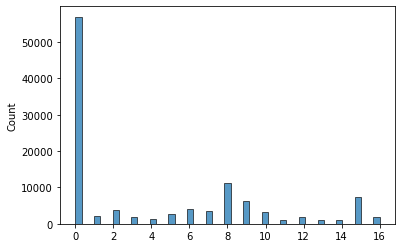

In [75]:
import seaborn as sn
ax_salinas = sn.histplot(label.flatten())
plt.show()

### Display the ground truth

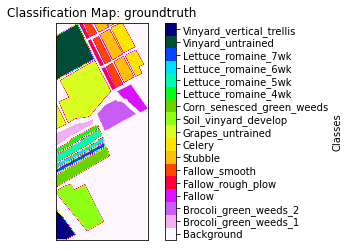

In [76]:
def display_class (data, title=''):
    fig, ax = plt.subplots()
    plt.imshow(data, cmap=plt.cm.get_cmap('gist_ncar_r', NUM_CLASSES + 1))
    plt.title('Classification Map: ' + title)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(label='Classes', boundaries=(np.arange(NUM_CLASSES + 2) - 0.5))
    cbar.set_ticks(np.arange(NUM_CLASSES + 1))
    cbar.set_ticklabels(GROUND_TRUTH)
    return None
display_class(label,'groundtruth')

### Plot the curve of one sample

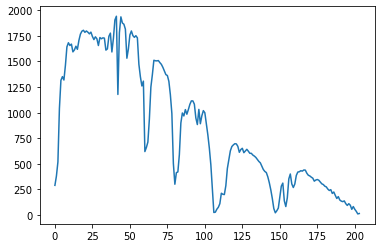

In [77]:
pos = [0, 1]
feature = data[pos[0], pos[1], :]
plt.plot(feature)

## Dataset Pre-possessing

#### Remark: The commented code is a test on our identified limitation:  Adding a Gaussian Blurring

In [78]:
# from skimage.filters import gaussian
# data = gaussian(data, sigma=5, channel_axis=True)

### 1. Reshape the 3-D image dataset into a 2-D structural data

In [79]:
data_2d = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
y_label = label.ravel()

### 2. Data Standardization

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X= scaler.fit_transform(data_2d)

### 3. Remove the samples labeled with 0

In [81]:
X = np.delete(data_2d, np.where(y_label == 0), axis = 0)
y = np.delete(y_label, np.where(y_label == 0))

In [82]:
print(X.shape)
print(y.shape)

(54129, 204)
(54129,)


## PCA

In [83]:
from sklearn.decomposition import PCA
pca= PCA(n_components=5, random_state=1)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=88)
print(X_train.shape)

(54129, 5)
(43303, 5)


## Gaussian Bayes Classifier (MAP)

In [106]:
# Bayesian
from scipy.stats import multivariate_normal
def fit(train,label):
    class_list = []
    for i in range(NUM_CLASSES):
        label_idx = np.argwhere(label == i+1).flatten()
        class_i = train[label_idx]
        class_list.append(class_i)

    mu_list = []
    cov_list = []
    prior = []
    for item in class_list:
        mu_class = np.mean(item,0)
        cov_class = np.cov(item, rowvar=False)
        prior_i = (item.shape[0]*item.shape[1])/len(label)
        prior.append(prior_i)
        mu_list.append(mu_class)
        cov_list.append(cov_class)
    return prior,mu_list,cov_list

def predict(prior, test, mu_list, cov_list):
    y = np.zeros((test.shape[0],NUM_CLASSES))
    for i in range(NUM_CLASSES):
        y1 = multivariate_normal.pdf(test, mu_list[i], cov_list[i])*prior[i]
        y[:,i]=y1
    y_pred = np.argmax(y, axis=1)+1
    return y_pred

### Cross Validation

In [107]:
skf = StratifiedKFold(n_splits=6)
cross_validate_scores = []
for train_index, validate_index in skf.split(X_train, y_train):
    x_train, x_validate = X_train[train_index], X_train[validate_index]
    y_sectrain, y_validate = y_train[train_index], y_train[validate_index]

    prior ,mu, cov = fit(x_train, y_sectrain)
    class_pred = predict(prior, x_validate, mu, cov)
    scores = accuracy_score(y_validate, class_pred)
    cross_validate_scores.append(scores)

print("The accuracy of cross validation is:",np.array(cross_validate_scores).mean())


The accuracy of cross validation is: 0.8934948090030801


### Prediction

In [108]:
prior,mu_list,cov_list=fit(X_train,y_train)
y_pred = predict(prior,X_test,mu_list,cov_list)

print(metrics.accuracy_score(y_test, y_pred)*100)
print(classification_report(y_test,y_pred))

89.42360982819139
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       386
           2       0.99      0.99      0.99       749
           3       0.91      1.00      0.95       385
           4       0.99      1.00      0.99       283
           5       0.99      0.92      0.95       521
           6       1.00      1.00      1.00       778
           7       1.00      0.99      0.99       724
           8       0.80      0.76      0.78      2271
           9       1.00      0.97      0.98      1259
          10       0.83      0.89      0.86       665
          11       0.96      0.98      0.97       245
          12       0.98      1.00      0.99       391
          13       0.99      0.98      0.98       166
          14       0.98      0.96      0.97       215
          15       0.67      0.72      0.69      1423
          16       0.96      0.98      0.97       365

    accuracy                           0.89     10826
   macro

### Plot the confusion matrix

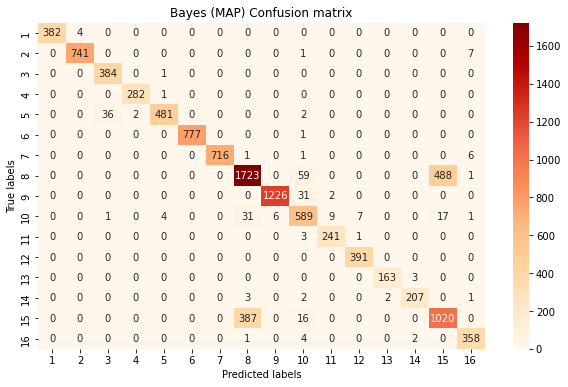

In [95]:
def plot_confusion_matrix(labels, preds, class_names, title='Bayes (MAP) Confusion matrix', log=False):
    # this function is from "plot.py" in "https://github.com/drguigui1/HSI-Classification/blob/main/src/plot.py"
    '''
    Plot the confusion matrix
    params
    ----------
    labels: Labels array of shape (n_samples,)
    preds: Predictions array of shape (n_samples,)
    class_names: Names of the different classes
    title: Title of the plot
    log: Logarithm plot
    '''
    # Plot confusion matrix using log / linear scale

    # Get confusion matrix and skip background (label 0)
    matrix = confusion_matrix(labels.flatten(), preds.flatten())

    df = pd.DataFrame({class_names[i]:matrix[:,i] for i in range(len(class_names))}, index=class_names)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot()
    ax.xaxis.set_ticks_position('bottom')
    if log:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g', norm=LogNorm())
    else:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g')

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.savefig('map.png')
    plt.show()

plot_confusion_matrix(y_test,y_pred,class_names=np.arange(1,17).astype(str),log=False)


### Plot the bar chart

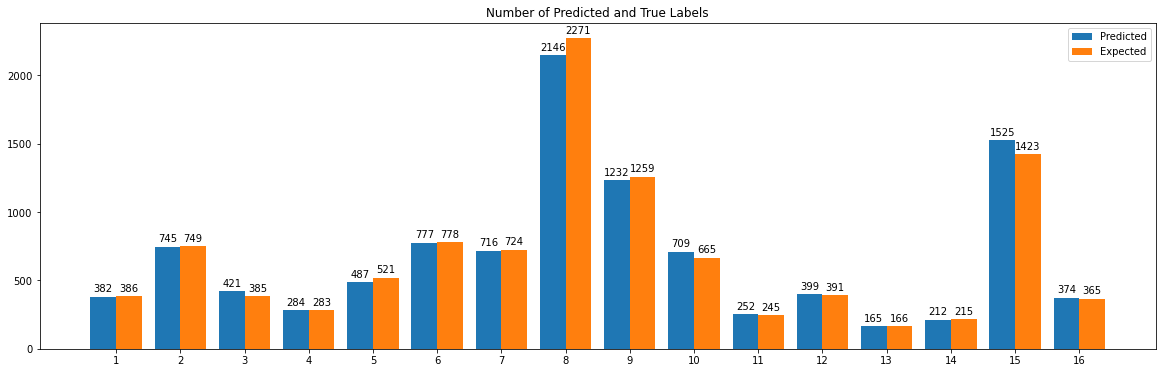

In [96]:
def plot_histogram_compare_predict_expect(predict, expect, title='Number of Predicted and True Labels'):
    '''
    Plot histogram and compare to predictions histogram
    params
    ----------
    predict: Predictions array of shape (n_samples,)
    expect: Expectations array of shape (n_samples,)
    title: Matplotlib title
    '''
    fig, axs = plt.subplots(figsize=(20, 6))

    bar_x, bar_count_pred = np.unique(predict, return_counts=True)
    bar1 = axs.bar(bar_x - 0.2, bar_count_pred, 0.4, label="Predicted")

    bar_x, bar_count_exp = np.unique(expect, return_counts=True)
    bar2 = axs.bar(bar_x + 0.2, bar_count_exp, 0.4, label="Expected")

    axs.bar_label(bar1, padding=3)
    axs.bar_label(bar2, padding=3)

    axs.set_xticks(np.arange(1,len(bar_x)+1))
    axs.set_xticklabels(bar_x)

    axs.set_title(title)
    axs.legend()
    plt.show()


plot_histogram_compare_predict_expect(y_pred,y_test,title = 'Number of Predicted and True Labels')


## Prediction on the whole image

In [97]:
prior,mu_list,cov_list=fit(X_pca,y)
y_pred_full = predict(prior, X_pca, mu_list, cov_list)
print(y_pred_full.shape)

(54129,)


In [98]:
# Padding the background for plotting
idx_arr1 = np.argwhere(y_label != 0).flatten()
salinas_img_pred = np.zeros((label.shape[0]*label.shape[1]))
salinas_img_pred[idx_arr1] = y_pred_full

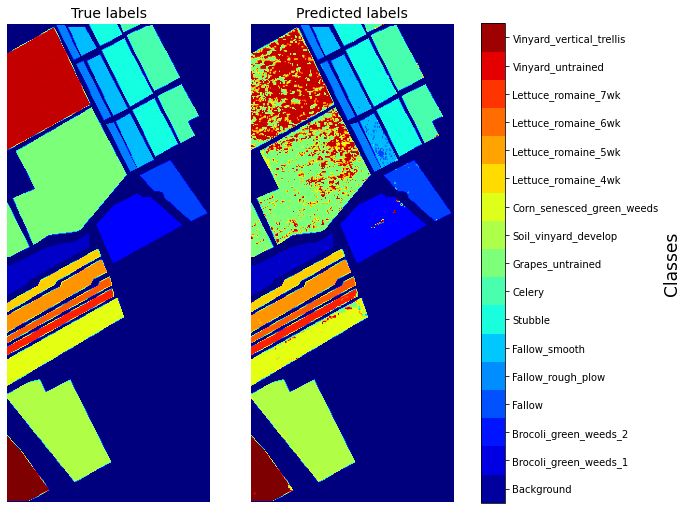

In [99]:
labels = np.dstack((label,salinas_img_pred.reshape((label.shape[0], label.shape[1]))))
titles = ['True labels', 'Predicted labels']
fig, axs = plt.subplots(1, 2, figsize=(10, 14))
for col in range(2):
    ax = axs[col]
    ax.axis('off')
    pcm = ax.imshow(labels[:,:,col], cmap='jet')
    ax.set_title(titles[col],fontdict = {'size':14})
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs.ravel().tolist(), boundaries=(np.arange(NUM_CLASSES + 2) - 0.5),shrink=0.63)
cbar.set_label('Classes', fontdict = {'size':17})
cbar.set_ticks(np.arange(NUM_CLASSES + 1))
cbar.set_ticklabels(GROUND_TRUTH)
plt.show()